##### 3_compileNysSPARCSAndHospitalFeatures

This notebook merges together the individual records of hospital discharges found on NYS Health site. The individual records are stored in files called [SPARCS (Statewide Planning and Research Cooperative System)](https://health.data.ny.gov/Health/Hospital-Inpatient-Discharges-SPARCS-De-Identified/gnzp-ekau). 

About SPARCS:
These records are updated and made available on annual basis. The latest publically available dataset is from 2016. Each annual file contains discharge level details regarding patient characteristics, diagnoses, treatments, services, and charges. The data is de-identified and redacted where information would disclose the identity of the patient. 

This individual level of data is merge together with data regarding the ratings of the Hospital by their provider and facility ids. These datasets are found on the CMS (Centers for Medicare and Medicaid Services) [site](https://data.medicare.gov/). The key datasets used in this project are:

- [Hospital General Information](https://data.medicare.gov/Hospital-Compare/Hospital-General-Information/xubh-q36u)
    - Provider Id
    - Hospital Ownership
    - Hospital Overall Rating
    - Mortality National Comparison
    - Readmission National Comparison
    - Safety of Care National Comparison
    - Effectiveness of Care National Comparison
    - Timeliness of Care National Comparison
    - Effecient Use of Medical Imaging National Comparison

- [Medicare Hospital Cost Report PUF 2014](https://data.cms.gov/Medicare-Inpatient/Medicare-Hospital-Cost-Report-PUF-2014/q74v-7825)
    - Provider CCN = Provider ID
    - Number of Beds
    - rural vs urban
    - fte employees on payroll
    - number of interns and 
    
- [PUMA](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2016&layergroup=Public+Use+Microdata+Areas)
    - Shape files for the New York State By Public Use Microdata Areas

- [Census Data](https://api.census.gov/data/2016/acs/acs1/variables.json)
    - "C27003_001E": "PUBLIC HEALTH INSURANCE STATUS BY SEX BY AGE"
    - "C27002_001E": "PRIVATE HEALTH INSURANCE STATUS BY SEX BY AGE"
    - "B00001_001E": "Unweighted Sample Count of the Population"

In order to complete the crosswalk between provider ids used in the CMS system to the facility ids used in the NY State Health system. Hospitals were looked up manually where necessary on [NYS Hospital Profiles](https://profiles.health.ny.gov/hospital/). 

In [1]:
import os
import sys
import io
import urllib.request
import requests
import json
import pandas as pd
import numpy as np

import geopandas as gpd
import shapely
import pysal as ps
import seaborn as sns
import sklearn.preprocessing as preprocessing

from geopandas.tools import sjoin
from fiona.crs import from_epsg
from pysal.contrib.viz import mapping as maps

import matplotlib.pyplot as plt
%matplotlib inline

print(sys.version)

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]


/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/pysal/contrib/viz/mapping.py:32: UserWarning: Bokeh not installed. Functionality related to it will not work
  warn('Bokeh not installed. Functionality '


In [2]:
dataFol = os.getcwd() + "/dataFiles/"
nysHealth = dataFol + "nysHealth/"
sparcsFol = nysHealth + "sparcs_raw/"

In [3]:
# Hospital Inpatient Discharges (SPARCS De-Identified)
# from https://health.data.ny.gov/Health/Hospital-Inpatient-Discharges-SPARCS-De-Identified/gnzp-ekau
# The Statewide Planning and Research Cooperative System (SPARCS) Inpatient De-identified File contains discharge
# level detail on patient characteristics, diagnoses, treatments, services, and charges. This data file contains 
# basic record level detail for the discharge. The de-identified data file does not contain data that is protected 
# health information (PHI) under HIPAA. The health information is not individually identifiable; all data elements 
# considered identifiable have been redacted. For example, the direct identifiers regarding a date have the day and 
# month portion of the date removed.

sparcsUrl = ["https://health.data.ny.gov/api/views/gnzp-ekau/rows.csv?accessType=DOWNLOAD", # sparcs 2016
             "https://health.data.ny.gov/api/views/82xm-y6g8/rows.csv?accessType=DOWNLOAD", # sparcs 2015
             "https://health.data.ny.gov/api/views/rmwa-zns4/rows.csv?accessType=DOWNLOAD", # sparcs 2014
             "https://health.data.ny.gov/api/views/npsr-cm47/rows.csv?accessType=DOWNLOAD"] # sparcs 2013

In [4]:
sparcsFiles = ["sparcs2016.csv", 
               "sparcs2015.csv",
               "sparcs2014.csv",
               "sparcs2013.csv"]

In [5]:
if not os.path.isdir(nysHealth):
    os.system("mkdir " + nysHealth)
else:
    print("you can continue")

you can continue


In [6]:
if not os.path.isdir(sparcsFol):
    os.system("mkdir " + sparcsFol)
else:
    print("you can continue")

you can continue


In [7]:
for sp in range(len(sparcsFiles)):
    ### check that the file is not already there
    if not os.path.isfile(sparcsFol + sparcsFiles[sp]):
        if os.path.isfile(sparcsFiles[sp]):
            # if in the current dir just move it
            os.system("mv " + sparcsFiles[sp] + " " + sparcsFol)
            print ("Moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(sparcsFiles[sp]):
                urllib.request.urlretrieve(sparcsUrl[sp], sparcsFiles[sp])
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + sparcsFiles[sp] + " " + sparcsFol)
    ### One final check:
    if not os.path.isfile(sparcsFol + sparcsFiles[sp]):
        print ("WARNING!!! something is wrong: the file is not there!")
    else:
        print ("file in place, you can continue")

file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue


In [8]:
collect_df = {}

for i in range(len(sparcsFiles)):
    df_name = sparcsFiles[i].split(".")[:-1][0]
    temp = pd.read_csv(sparcsFol + sparcsFiles[i], low_memory=False)
    temp['yr'] = sparcsFiles[i].split(".")[:-1][0][6:]
    temp.rename(columns={'Facility ID':'Facility Id'}, 
                 inplace=True)
    print(temp.shape)
    collect_df[df_name] = temp

(2343429, 39)
(2346931, 38)
(2367550, 38)
(2428905, 38)


In [9]:
sparcsAll = pd.concat(collect_df, ignore_index=True, keys=None, sort=False)

In [10]:
sparcsAll.head()

,Health Service Area,Hospital County,Operating Certificate Number,Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs,yr,Ratio of Total Costs to Total Charges
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,167816.0,167816.0,NaN,0,N,Y,5621.25,5037.17,2013,NaN
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,90301264.0,NaN,NaN,0,N,Y,2998.65,2940.46,2013,NaN
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,M,White,Not Span/Hispanic,...,90301264.0,NaN,NaN,0,N,Y,2037.00,2246.15,2013,NaN
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,50 to 69,147,F,White,Not Span/Hispanic,...,90301264.0,NaN,NaN,0,N,N,2435.75,2271.92,2013,NaN
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,M,White,Not Span/Hispanic,...,90301264.0,167816.0,NaN,0,N,Y,3754.95,3579.69,2013,NaN


In [11]:
sparcsAll.columns.tolist

<bound method IndexOpsMixin.tolist of Index(['Health Service Area', 'Hospital County',
       'Operating Certificate Number', 'Facility Id', 'Facility Name',
       'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity',
       'Length of Stay', 'Type of Admission', 'Patient Disposition',
       'Discharge Year', 'CCS Diagnosis Code', 'CCS Diagnosis Description',
       'CCS Procedure Code', 'CCS Procedure Description', 'APR DRG Code',
       'APR DRG Description', 'APR MDC Code', 'APR MDC Description',
       'APR Severity of Illness Code', 'APR Severity of Illness Description',
       'APR Risk of Mortality', 'APR Medical Surgical Description',
       'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3',
       'Attending Provider License Number',
       'Operating Provider License Number', 'Other Provider License Number',
       'Birth Weight', 'Abortion Edit Indicator',
       'Emergency Department Indicator', 'Total Charges', 'Total Costs', 'yr',
       'Rat

In [12]:
sparcsAll.drop(['Hospital County', 'Operating Certificate Number', 'Facility Name',
       'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity',
       'Patient Disposition', 'Discharge Year', 'CCS Diagnosis Code', 
       'CCS Diagnosis Description', 'CCS Procedure Code', 'CCS Procedure Description',
       'APR MDC Code', 'APR MDC Description', 'APR Medical Surgical Description',
       'Attending Provider License Number', 'Operating Provider License Number', 'Other Provider License Number',
       'Birth Weight', 'Abortion Edit Indicator', 'Ratio of Total Costs to Total Charges'], axis=1, inplace=True)

In [13]:
sparcsAll.columns.tolist

<bound method IndexOpsMixin.tolist of Index(['Health Service Area', 'Facility Id', 'Length of Stay',
       'Type of Admission', 'APR DRG Code', 'APR DRG Description',
       'APR Severity of Illness Code', 'APR Severity of Illness Description',
       'APR Risk of Mortality', 'Payment Typology 1', 'Payment Typology 2',
       'Payment Typology 3', 'Emergency Department Indicator', 'Total Charges',
       'Total Costs', 'yr'],
      dtype='object')>

##### Descriptive Stats on All Inpatient Discharges from SPARCS

##### By Year

In [14]:
sparcsAll.groupby(['yr']).count()[['APR DRG Code']]

,APR DRG Code
yr,
2013,2428905
2014,2367550
2015,2346931
2016,2343429


Appears to be fairly consistent the number of inpatient discharges in New York State between 2013 and 2016.

##### By Year and APR Risk of Mortality

In [15]:
sparcsAll.groupby(['yr', 'APR Risk of Mortality']).count()[['APR DRG Code']].pivot_table(index='APR Risk of Mortality', columns='yr')

APR DRG Code                           
yr                            2013     2014     2015     2016
APR Risk of Mortality                                        
Extreme                     106656   111737   121796   127199
Major                       312562   316461   335240   344937
Minor                      1488581  1436544  1389754  1376924
Moderate                    521063   502759   500030   494302

In [16]:
sparcsAll.groupby(['yr', 'APR Severity of Illness Description']).count()[['APR DRG Code']].pivot_table(index='APR Severity of Illness Description', columns='yr')

APR DRG Code                        
yr                                          2013    2014    2015    2016
APR Severity of Illness Description                                     
Extreme                                   129089  135805  146798  151900
Major                                     481616  494599  517086  527932
Minor                                     884614  828931  785636  774579
Moderate                                  933543  908166  897300  888951

In general it seems like there are more inpatient illnesses that are classified as "Minor" or "Moderate" than there are "Extreme" or "Major". This is true both from the 'APR Severity of Illness Description' and the 'APR Risk of Mortality' features. Also it looks like the APR Severity of Illness indicator has a code mapping to integers that reflect the levels of Minor > Moderate > Major > Extreme. Therefore, will drop the 2 description based columns.

In [17]:
sparcsAll.drop(['APR Severity of Illness Description', 'APR Risk of Mortality'], axis=1, inplace = True)

##### By Year and the Health Service Area

In [18]:
sparcsAll.groupby(['yr', 'Health Service Area']).count()[['APR DRG Code']].pivot_table(index='Health Service Area', columns='yr')

APR DRG Code                           
yr                          2013     2014     2015     2016
Health Service Area                                        
Capital/Adiron            164988   164949   167368   170367
Central NY                162781   157237   158342   158588
Finger Lakes              151454   147358   146581   150402
Hudson Valley             252343   244850   245956   248065
Long Island               352658   340905   339325   343072
New York City            1140284  1113931  1092204  1076433
Southern Tier              31236    29983    30201    29560
Western NY                170572   165945   164046   165949

Reviewing the 'Health Service Area' feature, it looks like Long Island and New York City are the areas with the most inpatient discharges. This is probably highly correlated with the population sizes in these respective areas. 

##### By Severity of Illness and the APR DRG Description

In [19]:
sparcsAll.groupby(['APR Severity of Illness Code', 'APR DRG Description']).count() \
[['APR DRG Code']].pivot_table(index='APR DRG Description', columns='APR Severity of Illness Code')

APR DRG Code            \
APR Severity of Illness Code                                  0         1   
APR DRG Description                                                         
Abdominal pain                                              NaN   10361.0   
Abortion w/o D&C, aspiration curettage or hyste...          NaN    2288.0   
Acute & subacute endocarditis                               NaN     144.0   
Acute anxiety & delirium states                             NaN    7224.0   
Acute leukemia                                              NaN     468.0   
Acute major eye infections                                  NaN     733.0   
Acute myocardial infarction                                 NaN   10666.0   
Adjustment disorders & neuroses except depressi...          NaN   10770.0   
Alcohol & drug dependence w rehab or rehab/deto...          NaN   20795.0   
Alcohol abuse & dependence                                  NaN   31350.0   
Alcoholic liver disease                                     NaN     452.0   
Allergic reactions                                          NaN    3778.0   
Amputation of lower limb except toes                        NaN     550.0   
Anal procedures                                             NaN    4297.0   
Angina pectoris & coronary atherosclerosis                  NaN   22550.0   
Appendectomy                                                NaN   33404.0   
Asthma                                                      NaN   43512.0   
BPD & oth chronic respiratory diseases arising ...          NaN     116.0   
Bacterial & tuberculous infections of nervous s...          NaN     181.0   
Behavioral disorders                                        NaN    3156.0   
Bipolar disorders                                           NaN   40505.0   
Bone marrow transplant                                      NaN    1514.0   
Brain contusion/laceration & complicated skull ...          NaN     821.0   
Breast procedures except mastectomy                         NaN    2377.0   
Bronchiolitis & RSV pneumonia                               NaN   13679.0   
Burns with skin graft except extensive 3rd degr...          NaN     460.0   
CHEMOTHERAPY                                                NaN    3375.0   
CVA & precerebral occlusion w infarct                       NaN   12525.0   
Cardiac arrest and shock                                    NaN     103.0   
Cardiac arrhythmia & conduction disorders                   NaN   34817.0   
...                                                         ...       ...   
Skin graft for skin & subcutaneous tissue diagn...          NaN    3447.0   
Skin graft, except hand, for musculoskeletal & ...          NaN     610.0   
Skin ulcers                                                 NaN    1310.0   
Spinal disorders & injuries                                 NaN     506.0   
Spinal procedures                                           NaN    5317.0   
Splenectomy                                                 NaN     364.0   
Syncope & collapse                                          NaN   22675.0   
Tendon, muscle & other soft tissue procedures               NaN    5018.0   
Testes & scrotal procedures                                 NaN    1482.0   
Thyroid, parathyroid & thyroglossal procedures              NaN    7574.0   
Tonsil & adenoid procedures                                 NaN    4417.0   
Toxic effects of non-medicinal substances                   NaN    3508.0   
Tracheostomy w MV 96+ hours w extensive procedu...          NaN      21.0   
Tracheostomy w MV 96+ hours w/o extensive proce...          NaN       4.0   
Transient ischemia                                          NaN   11131.0   
Transurethral prostatectomy                                 NaN    4709.0   
Ungroupable                                                69.0       NaN   
Urethral & transurethral procedures                         NaN    4126.0   
Urinary stones & acquired upper urinary tract o

In [20]:
 sparcsAll['APR Severity of Illness Code'] = sparcsAll['APR Severity of Illness Code'].replace(0, np.nan)

Getting a quick glance at APR Illness and the severity. It seems like it is as expected where cases such as 'Amputation' are mostly major and extreme compare to how 'Vertigo' is mostly minor and moderate. 

##### What are the top 10 APR DRG Descriptions for Inpatient Discharges?

In [21]:
top10APRDrg = sparcsAll.groupby('APR DRG Code').count()[['Type of Admission']]\
.reset_index().sort_values(by='Type of Admission', ascending=False).head(10)

top10APRDrg

,APR DRG Code,Type of Admission
249,640,801036
216,560,586432
265,720,347170
210,540,305540
85,194,221503
59,139,173187
60,140,165163
133,302,150077
164,383,143530
271,750,142356


In [22]:
sparcsByAPR = sparcsAll.groupby(['yr', 'APR DRG Code', 'APR DRG Description']).count()\
.pivot_table(index=['APR DRG Code', 'APR DRG Description'], columns='yr')

In [23]:
top50APRDrg = sparcsByAPR.reindex(sparcsByAPR['Facility Id'].sort_values(by='2016', ascending=False).index).head(50)['Facility Id']

In [24]:
top50APRDrg

,yr,2013,2014,2015,2016
APR DRG Code,APR DRG Description,,,,
640,"Neonate birthwt >2499g, normal newborn or neonate w other problem",203998,203593,198207,195238
560,Vaginal delivery,147403,149696,146813,142108
720,Septicemia & disseminated infections,74007,84732,95074,93348
540,Cesarean delivery,77872,77008,76088,74558
194,Heart failure,54187,54241,56366,56707
139,Other pneumonia,47076,42210,43009,40890
302,Knee joint replacement,35243,36511,38499,39824
140,Chronic obstructive pulmonary disease,44845,41528,40767,38023
750,Schizophrenia,34279,36090,35651,36329


Getting a sense of what are the top 50 APR codes and their descriptions and the count of the number of discharges per year between 2013 and 2016. Then only using the top 10.

In [25]:
# list of top 10 APR DRG Codes
top10APRDrgCode = top10APRDrg.reset_index()['APR DRG Code'].values
top10APRDrgCode

array([640, 560, 720, 540, 194, 139, 140, 302, 383, 750])

##### What about the Total Charges?

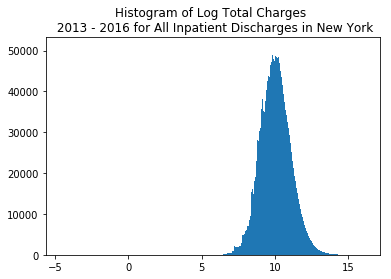

In [26]:
plt.hist(np.log(sparcsAll['Total Charges']), bins='auto')
plt.title("Histogram of Log Total Charges \n 2013 - 2016 for All Inpatient Discharges in New York")
plt.savefig('figures/histogramLogAllTotalCharges20132016.png')

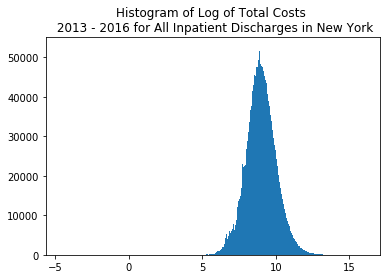

In [27]:
plt.hist(np.log(sparcsAll[sparcsAll['Total Costs'] > 0]['Total Costs']), bins='auto')
plt.title("Histogram of Log of Total Costs \n 2013 - 2016 for All Inpatient Discharges in New York")
plt.savefig('figures/histogramLogAllTotalCosts20132016.png')

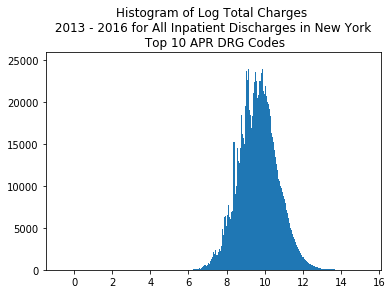

In [65]:
plt.hist(np.log(sparcsAll[sparcsAll['APR DRG Code'].isin(top10APRDrgCode)]['Total Charges']), bins='auto')
plt.title("Histogram of Log Total Charges \n 2013 - 2016 for All Inpatient Discharges in New York \n Top 10 APR DRG Codes")
plt.savefig('figures/histogramTop10TotalCharges20132016.png')

In [29]:
sparcsAll[sparcsAll['APR DRG Code'].isin(top10APRDrgCode)]['Total Charges'].describe()

count    3.035994e+06
mean     2.638673e+04
std      4.082160e+04
min      5.000000e-01
25%      7.907380e+03
50%      1.548608e+04
75%      2.973317e+04
max      4.302119e+06
Name: Total Charges, dtype: float64

In [30]:
sparcsAll[sparcsAll['APR DRG Code'].isin(top10APRDrg.reset_index()['APR DRG Code'].values)]\
.groupby(['yr', 'APR DRG Code', 'APR DRG Description']).mean()[['Total Charges', 'Total Costs']]\
.pivot_table(index=['APR DRG Code', 'APR DRG Description'], columns='yr')

Total Charges  \
yr                                                                       2013   
APR DRG Code APR DRG Description                                                
139          Other pneumonia                                     28253.906186   
140          Chronic obstructive pulmonary disease               26331.386974   
194          Heart failure                                       34112.320180   
302          Knee joint replacement                              48975.197039   
383          Cellulitis & other skin infections                  22674.150896   
540          Cesarean delivery                                   22313.868134   
560          Vaginal delivery                                    13145.291818   
640          Neonate birthwt >2499g, normal newborn or neona...   6434.856896   
720          Septicemia & disseminated infections                56348.432311   
750          Schizophrenia                                       49170.686209   

                                                                               \
yr                                                                       2014   
APR DRG Code APR DRG Description                                                
139          Other pneumonia                                     29992.321382   
140          Chronic obstructive pulmonary disease               28458.256409   
194          Heart failure                                       36885.840518   
302          Knee joint replacement                              51388.080477   
383          Cellulitis & other skin infections                  24144.691416   
540          Cesarean delivery                                   24821.914107   
560          Vaginal delivery                                    14599.312441   
640          Neonate birthwt >2499g, normal newborn or neona...   7290.356610   
720          Septicemia & disseminated infections                57552.659817   
750          Schizophrenia                                       50772.826787   

                                                                               \
yr                                                                       2015   
APR DRG Code APR DRG Description                                                
139          Other pneumonia                                     31311.155180   
140          Chronic obstructive pulmonary disease               29666.493179   
194          Heart failure                                       38969.749632   
302          Knee joint replacement                              55321.213112   
383          Cellulitis & other skin infections                  25929.735702   
540          Cesarean delivery                                   26893.017074   
560          Vaginal delivery                                    15797.051259   
640          Neonate birthwt >2499g, normal newborn or neona...   8037.731672   
720          Septicemia & disseminated infections                59239.885398   
750          Schizophrenia                                       50449.093339   

                                                                               \
yr                                                                       2016   
APR DRG Code APR DRG Description                                                
139          Other pneumonia                                     32529.756786   
140          Chronic obstructive pulmonary disease               31163.112219   
194          Heart failure                                       41191.123601   
302          Knee joint replacement                              58500.807780   
383          Cellulitis & other skin infections                  26389.411776   
540          Cesarean delivery                                   28716.755465   
560          Vaginal delivery                                    16802.129762   
640          Neonate birthwt >2499g, normal newborn or neona...   8617.167433   
720        

Looks very consistent at the means that there is an upward trend in average total charges from 2013 to 2016 per APR DRG.

##### Get the Hospital Facility and Provider Id Cross Walk
This includes the location - lat and longs

In [31]:
# based on dataset from https://data.medicare.gov/Hospital-Compare/Hospital-General-Information/xubh-q36u
# manual crosswalk from provider id to facility id in googlesheet found here:
# https://docs.google.com/spreadsheets/d/1F8yPe-2uMcAOOzRmYnFenC77GiXnJ0afnRXtBUYe5TQ/edit#gid=1213013033
providerFacIdCrossWalk = pd.read_csv(dataFol + 'cms/nysHospitalsProviderIdFacilityIdCrossWalk.csv')

In [32]:
providerFacIdCrossWalk.drop(['Unnamed: 0', 'in_nyc', 'Hospital Name',
       'Address', 'City', 'State', 'ZIP Code', 'County Name', 'Phone Number',
       'Hospital Type', 'Emergency Services',
       'Meets criteria for meaningful use of EHRs', 
       'Hospital overall rating footnote',
       'Mortality national comparison footnote',
       'Safety of care national comparison footnote',
       'Readmission national comparison footnote',
       'Patient experience national comparison footnote',
       'Effectiveness of care national comparison footnote',
       'Timeliness of care national comparison footnote',
       'Efficient use of medical imaging national comparison footnote'], axis=1, inplace=True)

In [33]:
# extract the lat and long and merge back onto the providerFacIdCrossWalk df
lcnSplit = providerFacIdCrossWalk['Location'].str.split(pat='(', expand=True)[1].str.split(pat=(','), expand=True)
providerFacIdCrossWalk['lat'] = lcnSplit[0]
providerFacIdCrossWalk['long'] = lcnSplit[1].str.split(pat=(')'), expand=True)[0]

In [34]:
providerFacIdCrossWalk.drop(['Location'], axis=1, inplace=True)

##### Mapping the categorical variables into levels that map to integers

- 'Not Available' : nan
- 'Below the national average': -1 
- 'Same as the national average': 0
- 'Above the national average': 1

In [35]:
providerFacIdCrossWalk['Hospital overall rating'] = pd.to_numeric(providerFacIdCrossWalk['Hospital overall rating'], 
                                                                  errors='coerce')

In [36]:
rating_lvls = {'Below the national average': -1,
  'Same as the national average': 0,
  'Above the national average': 1,
  'Not Available': np.nan}

In [37]:
for i in range(4,11):
    providerFacIdCrossWalk.iloc[:, i].replace(rating_lvls, inplace=True)

In [38]:
providerFacIdCrossWalk.head()

,Provider ID,fac_id,Hospital Ownership,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison,lat,long
0,330013,1.0,Voluntary non-profit - Private,2.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,42.653254,-73.77386
1,330003,4.0,Voluntary non-profit - Private,3.0,0.0,0.0,1.0,-1.0,0.0,-1.0,NaN,42.674685,-73.748861
2,330057,5.0,Voluntary non-profit - Private,3.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,0.0,42.660176,-73.802382
3,331301,37.0,Voluntary non-profit - Private,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,42.213341,-78.288139
4,330096,39.0,Voluntary non-profit - Private,2.0,0.0,NaN,1.0,-1.0,0.0,0.0,NaN,42.122878,-77.949784


##### Get the PUMA shape files

In [39]:
# get the New York State Shape Files
# manual download fr. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2016&layergroup=Public+Use+Microdata+Areas
# move into the dataFols directory
# get the hosp puf dictionary
if not os.path.isdir(dataFol + 'tl_2016_36_puma10'):
    os.system('mkdir ' + dataFol + '/tl_2016_36_puma10')
    os.system('unzip -d ' + dataFol + '/tl_2016_36_puma10 ' + dataFol + 'tl_2016_36_puma10.zip')
else:
    print("you can continue")

you can continue


In [40]:
# then read it in with geopandas, reading in the shape file with the function 
pumashp = gpd.GeoDataFrame.from_file(dataFol + '/tl_2016_36_puma10/' + 'tl_2016_36_puma10.shp')

In [41]:
pumashp.head()

,STATEFP10,PUMACE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,36,03803,3603803,NYC-Manhattan Community District 10--Central H...,G6120,S,3703010,241237,+40.8137240,-073.9429990,"POLYGON ((-73.95150599999999 40.812008, -73.95..."
1,36,03707,3603707,NYC-Bronx Community District 5--Morris Heights...,G6120,S,3911380,24513,+40.8528801,-073.9087693,POLYGON ((-73.90980999999999 40.85734799999999...
2,36,03201,3603201,Nassau County (Northwest)--North Hempstead Tow...,G6120,S,99590466,40464509,+40.8170441,-073.6919814,"POLYGON ((-73.628102 40.816038, -73.627775 40...."
3,36,03301,3603301,Suffolk County (Northwest)--Huntington Town (N...,G6120,S,117124211,39091315,+40.8985365,-073.3956826,"POLYGON ((-73.34566099999999 40.935497, -73.32..."
4,36,03303,3603303,Suffolk County (Northwest)--Smithtown Town PUMA,G6120,S,139096977,18843675,+40.8704498,-073.2169705,"POLYGON ((-73.24163799999999 40.915457, -73.23..."


In [42]:
pumashp.shape

(145, 11)

In [43]:
pumashp.crs

# CRS are important because the geometric shapes in a GeoSeries or GeoDataFrame object are simply a collection of 
# coordinates in an arbitrary space. A CRS tells Python how those coordinates related to places on the Earth. 
# CRS are referred to using codes called proj4 strings.

{'init': 'epsg:4269'}

In [44]:
# reference from Chris Prince's notebook
# combine lat and lon to one column
providerFacIdCrossWalk['lonlat'] = list(zip(pd.to_numeric(providerFacIdCrossWalk.long), pd.to_numeric(providerFacIdCrossWalk.lat)))

# Create Point Geometry for based on lonlat column
providerFacIdCrossWalk['geometry'] = providerFacIdCrossWalk[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [45]:
providerFacIdCrossWalk.head()

,Provider ID,fac_id,Hospital Ownership,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison,lat,long,lonlat,geometry
0,330013,1.0,Voluntary non-profit - Private,2.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,0.0,42.653254,-73.77386,"(-73.77386, 42.653254)",POINT (-73.77386 42.653254)
1,330003,4.0,Voluntary non-profit - Private,3.0,0.0,0.0,1.0,-1.0,0.0,-1.0,NaN,42.674685,-73.748861,"(-73.748861, 42.674685)",POINT (-73.74886100000001 42.674685)
2,330057,5.0,Voluntary non-profit - Private,3.0,0.0,-1.0,1.0,-1.0,0.0,-1.0,0.0,42.660176,-73.802382,"(-73.802382, 42.660176)",POINT (-73.80238199999999 42.660176)
3,331301,37.0,Voluntary non-profit - Private,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,42.213341,-78.288139,"(-78.288139, 42.213341)",POINT (-78.288139 42.213341)
4,330096,39.0,Voluntary non-profit - Private,2.0,0.0,NaN,1.0,-1.0,0.0,0.0,NaN,42.122878,-77.949784,"(-77.949784, 42.122878)",POINT (-77.94978399999999 42.122878)


In [46]:
crs = {'init': 'epsg:4269'}
providersGDF = gpd.GeoDataFrame(providerFacIdCrossWalk[providerFacIdCrossWalk['lat'].notnull()], crs=crs) # making it into a geodataframe

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


Text(0.5, 1.0, 'Map of New York State Hospitals')

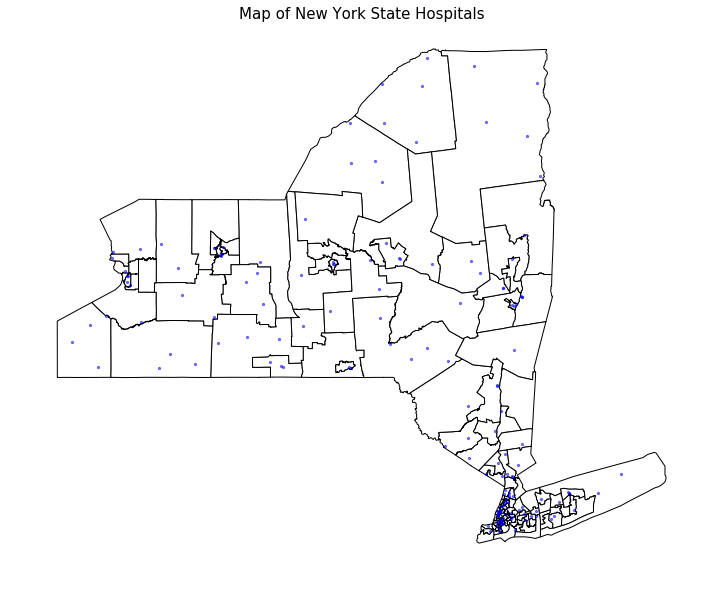

In [47]:
## plotting once using the pylab
# Setup figure and axis
f, ax = plt.subplots(1, figsize = (12,10))
# Plot layer of polygons on the axis
pumashp.plot(ax = ax ,color = 'white',edgecolor = 'black')
providersGDF.plot(ax=ax, column = 'Provider ID', 
                       marker="o", markersize = 5, 
                       color = 'blue', alpha = 0.5)

# Remove axis frames
ax.set_axis_off()
# Display
plt.title('Map of New York State Hospitals', fontdict = {'fontsize' : 15})

##### perform spatial join to get the PUMA label per facility id/ provider id

In [48]:
## This snippet is from Chris Prince
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False


a=[]
#setup a progressbar
if hasWidgets:
    pb = widgets.FloatProgress(min=0, max=1, description="Creating pts:")
    display(pb)
step = 0.05
updatestep = 0

# check for each linkNYC to see what puma they are belong to

for i in range(len(providersGDF)):
    a.append(pumashp[pumashp.geometry.intersects(providersGDF.iloc[i].geometry)].PUMACE10.values[0])
    progress = (i+1)/len(providersGDF)
    curstep = progress//step
    if hasWidgets:
        pb.value = progress
    elif updatestep!=curstep:
        # should use /r, but this is currently broken in jupyterlab, see https://github.com/jupyterlab/jupyterlab/issues/5326
        print ('{:.0f}%'.format(progress*100), end=" ")
        updatestep=curstep
providersGDF['Provider ID'] = a
if hasWidgets: pb.description = "Done!"
else: print ("100%")

5% 10% 15% 21% 26% 30% 35% 40% 46% 51% 55% 60% 65% 71% 76% 80% 85% 90% 96% 100%


In [49]:
providersGDF.crs = from_epsg(4269)
pumashp.crs

{'init': 'epsg:4269'}

In [50]:
providersGDF.crs

{'init': 'epsg:4269', 'no_defs': True}

In [51]:
pumashp.crs

{'init': 'epsg:4269'}

In [52]:
providersGDF_ft = providersGDF.to_crs(epsg=2263)
puma_ft = pumashp.to_crs(epsg=2263)

In [53]:
providersPuma = gpd.sjoin(providersGDF_ft, puma_ft)

In [54]:
providersPuma['puma'] = pd.to_numeric(providersPuma['PUMACE10'])

##### Get Census Data

In [55]:
if not os.path.isfile(dataFol + 'tl_2016_36_puma10/censusDataPuma.csv'):
    #import sys
    sys.path.insert(0,"%s/keys/"%os.getenv("HOME"))
    # Get my saved API key
    import censusAPI
    from censusAPI import myAPI
    
    #read in in the variables available. the info you need is in the 1year ACS data
    url = "https://api.census.gov/data/2012/acs/acs1/variables.json"
    resp = requests.request('GET', url)
    aff1y = json.loads(resp.text)
    #turning things into arrays to enable broadcasting
    affkeys = np.array(list(aff1y['variables'].keys()))
    
    key1 = 'B01003_001E' # key variable for "TOTAL POPULATION"
    key2 = 'C27002_001E' # key var for "PRIVATE HEALTH INSURANCE STATUS BY SEX BY AGE"
    key3 = 'B99132_001E' # key var for "Allocation of Fertility of women 15 to 50 years"

    # getting the total population
    aff_url1 = "https://api.census.gov/data/2016/acs/acs1?get=" + key1 +\
    ",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
    resp1 = requests.request('GET', aff_url1).content
    
    try:
        puma_pop = pd.read_csv(io.StringIO(resp1.decode('utf-8').replace('[','').replace(']','')))
    except:
        print("An exception occurred")
    
    # getting the total private insurance
    aff_url2 = "https://api.census.gov/data/2016/acs/acs1?get=" + key2 +\
    ",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
    resp2 = requests.request('GET', aff_url2).content
    
    try:
        puma_ins = pd.read_csv(io.StringIO(resp2.decode('utf-8').replace('[','').replace(']','')))
    except:
        print("An exception occurred")

    # getting the total public insurance
    aff_url3 = "https://api.census.gov/data/2016/acs/acs1?get=" + key3 +\
    ",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
    resp3 = requests.request('GET', aff_url3).content

    try:
        puma_fertility = pd.read_csv(io.StringIO(resp3.decode('utf-8').replace('[','').replace(']','')))
    except:
        print("An exception occurred")
        
    censusPuma = puma_pop[['public use microdata area', 'B01003_001E']] \
    .merge(puma_ins[['C27002_001E', 'public use microdata area']], on='public use microdata area') \
    .merge(puma_fertility[['B99132_001E', 'public use microdata area']], on='public use microdata area')
    
    censusPuma.rename(index=str, 
                      columns={"B01003_001E": "totalPopulation", 
                               "C27002_001E": "totalInsured", 
                               "B99132_001E":"totalFertile"}, 
                      inplace=True)
    
    censusPuma.to_csv('dataFiles/tl_2016_36_puma10/censusDataPuma.csv')
    
else:
    censusPuma = pd.read_csv('dataFiles/tl_2016_36_puma10/censusDataPuma.csv')

In [56]:
censusPuma.head()

,Unnamed: 0,public use microdata area,totalPopulation,totalInsured,totalFertile
0,0,100,110038,106389,24870
1,1,200,173406,161297,35839
2,2,300,126367,122820,25584
3,3,401,116527,115622,25532
4,4,402,160689,153554,34186


##### Merge On Hospital Features

In [57]:
# read in the data on hospital features found on CMS
# https://data.cms.gov/Medicare-Inpatient/Medicare-Hospital-Cost-Report-PUF-2014/q74v-7825
hospFeat = pd.read_json("https://data.cms.gov/resource/8rp3-rzmi.json?state_code=NY")
hospFeat.to_csv(dataFol + 'cms/medicareHospitalCostReportPUF2014.csv')

In [58]:
# url for the hosp features dataset (puf) dictionary
pufUrl = 'https://data.cms.gov/api/views/q74v-7825/files/af6d9b58-0f4a-4e0f-815e-ad0ea39ad846?download=true&filename=CostReport_Documentation_2014_Final_Oct_2018.zip'

In [59]:
# get the hosp puf dictionary
if not os.path.isfile(dataFol + 'cms/CostReport_Documentation_2014_Final_Oct 2018.xlsx'):
    urllib.request.urlretrieve(pufUrl, 'CostReport_Documentation_2014_Final_Oct_2018.zip')
    os.system("mv " + "CostReport_Documentation_2014_Final_Oct_2018.zip " + dataFol + 'cms')
    os.system('unzip -d ' + dataFol + 'cms ' + dataFol + '/cms/CostReport_Documentation_2014_Final_Oct_2018.zip')
else:
    print("you can continue")

you can continue


In [60]:
hospFeat.drop(['accounts_payable',
 'accounts_receivable',
 'allowable_dsh_percentage',
 'buildings',
 'cash_on_hand_and_in_banks',
 'ccn_facility_type',
 'city',
 'combined_outpatient_inpatient',
 'contract_labor',
 'cost_of_charity_care',
 'cost_of_uncompensated_care',
 'cost_to_charge_ratio',
 'county',
 'deferred_income',
 'depreciation_cost',
 'disproporationate_share',
 'drg_amounts_after_october',
 'drg_amounts_before_october',
 'fiscal_year_begin_date',
 'fiscal_year_end_date',
 'fixed_equipment',
 'general_fund_balance',
 'gross_revenue',
 'health_information_technology',
 'hospital_name',
 'hospital_number_of_beds_for',
 'hospital_total_bed_days',
 'hospital_total_days_title_1',
 'hospital_total_days_title_2',
 'hospital_total_days_v_xviii',
 'hospital_total_discharges_1',
 'hospital_total_discharges_2',
 'hospital_total_discharges_3',
 'inpatient_revenue',
 'inpatient_total_charges',
 'inventory',
 'investments',
 'land',
 'land_improvements',
 'leasehold_improvements',
 'less_allowances_for',
 'less_contractual_allowance',
 'less_total_operating_expense',
 'major_movable_equipment',
 'managed_care_simulated',
 'medicaid_charges',
 'medicare_cbsa_number',
 'minor_equipment_depreciable',
 'mortgage_payable',
 'net_income',
 'net_income_from_service_to',
 'net_patient_revenue',
 'net_revenue_from_medicaid',
 'net_revenue_from_stand_alone',
 'notes_and_loans_payable_short',
 'notes_payable',
 'notes_receivable',
 'number_of_beds_total_for',
 'other_assets',
 'other_current_assets',
 'other_current_liabilities',
 'other_long_term_liabilities',
 'outlier_payments_for',
 'outpatient_revenue',
 'outpatient_total_charges',
 'overhead_non_salary_costs',
 'payroll_taxes_payable',
 'prepaid_expenses',
 'provider_type',
 'salaries_wages_and_fees',
 'stand_alone_schip_charges',
 'state_code',
 'street_address',
 'temporary_investments',
 'total_assets',
 'total_bad_debt_expense',
 'total_bed_days_available',
 'total_bed_days_available_1',
 'total_costs',
 'total_current_assets',
 'total_current_liabilities',
 'total_days_title_xix',
 'total_days_title_xix_total',
 'total_days_title_xviii',
 'total_days_title_xviii_total',
 'total_days_v_xviii_xix_unknown',
 'total_days_v_xviii_xix_unknown_1',
 'total_discharges_title_xix',
 'total_discharges_title_xix_1',
 'total_discharges_title_xviii',
 'total_discharges_title_xviii_1',
 'total_discharges_v_xviii',
 'total_discharges_v_xviii_1',
 'total_fixed_assets',
 'total_fund_balances',
 'total_ime_payment',
 'total_income',
 'total_liabilities',
 'total_liabilities_and_fund',
 'total_long_term_liabilities',
 'total_other_assets',
 'total_other_expenses',
 'total_other_income',
 'total_salaries_adjusted',
 'total_salaries_from_worksheet',
 'total_unreimbursed_and',
 'type_of_control',
 'unsecured_loans',
 'wage_related_costs_core',
 'wage_related_costs_for_interns',
 'wage_related_costs_for_part',
 'wage_related_costs_rhc_fqhc',
 'zip_code'], axis=1, inplace=True)

In [61]:
aprHospFeat = sparcsAll[(sparcsAll['APR DRG Code'].isin(top10APRDrgCode))] \
.merge(providerFacIdCrossWalk, left_on='Facility Id', right_on='fac_id', how='inner') \
.merge(hospFeat, left_on='Provider ID', right_on='provider_ccn', how='inner') \
.merge(providersPuma[['fac_id', 'puma']], left_on='Facility Id', right_on='fac_id', how='outer') \
.merge(censusPuma, left_on='puma', right_on='public use microdata area', how='outer')

In [63]:
aprHospFeat.drop(['Unnamed: 0', 'fac_id_x', 'fac_id_y', 
                  'provider_ccn', 'public use microdata area'], axis=1, 
                inplace=True)

In [64]:
aprHospFeat.to_csv(dataFol + 'compiledDischargesHospitalFeaturesCensus.csv')

In [66]:
aprHospFeat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2551506 entries, 0 to 2551505
Data columns (total 36 columns):
Health Service Area                                     object
Facility Id                                             float64
Length of Stay                                          object
Type of Admission                                       object
APR DRG Code                                            float64
APR DRG Description                                     object
APR Severity of Illness Code                            float64
Payment Typology 1                                      object
Payment Typology 2                                      object
Payment Typology 3                                      object
Emergency Department Indicator                          object
Total Charges                                           float64
Total Costs                                             float64
yr                                                      object
